# Capstone Project - Distracted Driver Detection - CNN with no data leakage

In this notebook, we will be addressing the issue of data leakage in the validation data by splitting the data by driver ID.

This is to prevent images of the same driver being in the validation data when we train our CNN model.

By this manual splitting of the data, we are hoping to obtain a more realistic accuracy of the model when training with the dataset.

# Import libraries

In [ ]:
#import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns 
import os
import cv2
import itertools
import random

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator


%matplotlib inline

# Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import Dataset

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/capstone/datasets/driver_imgs_list.csv")
print('Number of samples in trainset : {}'.format(train.shape[0]))
print('Number of classes to predict : {}'.format(len((train.classname).unique())))
train.head()

Number of samples in trainset : 22424
Number of classes to predict : 10


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


# Split data set by driver id

In [ ]:
def custom_train_test_split_images(train_subjects, 
                                   test_subjects,
                                   val_subjects,
                                   dataDir = "/content/drive/MyDrive/capstone/assets/imgs/train", 
                                   labels= ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'],
                                   train=train,
                                   shuffle=True):
    
    x_train, x_val, x_test, y_train, y_val, y_test = [],[],[],[],[],[]
    
    for label in labels:
        path = os.path.join(dataDir, label) #path to labels directory
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #read image, convert to grayscale
            new_array = cv2.resize(img_array, (100, 100)) #resize
            
            current_subject = train.loc[train['img'] == img, 'subject'].item() #locate all images relating to a driver
            
            if current_subject in train_subjects:
                x_train.append(new_array)
                y_train.append(class_num)
                
            elif current_subject in test_subjects:
                x_test.append(new_array)
                y_test.append(class_num)
                
            elif current_subject in val_subjects:
                x_val.append(new_array)
                y_val.append(class_num)

    if shuffle: #shuffle data
        train_tmp, val_tmp, test_tmp = list(zip(x_train, y_train)), list(zip(x_val, y_val)), list(zip(x_test, y_test))
        random.shuffle(train_tmp)
        random.shuffle(val_tmp)
        random.shuffle(test_tmp)
        
        x_train, y_train = list(zip(*train_tmp))
        x_val, y_val = list(zip(*val_tmp))
        x_test, y_test = list(zip(*test_tmp))

    return x_train, x_val, x_test, y_train, y_val, y_test
            

In [ ]:
#code was run on jupyter notebook

# drivers = train.groupby('subject')
# unique_drivers = drivers.groups.keys()

# train_ratio = .5
# test_ratio = .25
# train_subject_len = int(np.floor(len(unique_drivers) * train_ratio))
# test_subject_len = int(np.floor(len(unique_drivers) * (train_ratio + test_ratio)))


# train_subjects = list(unique_drivers)[:train_subject_len]
# test_subjects = list(unique_drivers)[train_subject_len:test_subject_len]
# val_subjects = list(unique_drivers)[test_subject_len:]

# print('train subjects: ', train_subjects)
# print('test subjects: ', test_subjects)
# print('val subjects: ', val_subjects)


# X_train, X_val, X_test, y_train, y_val, y_test = custom_train_test_split_images(train_subjects=train_subjects, 
#                                         test_subjects=test_subjects, 
#                                         val_subjects=val_subjects)

# Preprocess data

In [ ]:
#code was run on jupyter notebook

# def preprocess(x_train, x_val, x_test, y_train, y_val, y_test):
#     x_train = np.array(x_train, dtype=np.float32)
#     x_val = np.array(x_val, dtype=np.float32)
#     x_test = np.array(x_test, dtype=np.float32)
    
#     x_train_flat = x_train.reshape(x_train.shape[0],-1)
#     x_val_flat = x_val.reshape(x_val.shape[0],-1)
#     x_test_flat = x_test.reshape(x_test.shape[0],-1)
    
#     ss = StandardScaler()
#     x_train_flat = ss.fit_transform(x_train_flat)
#     x_train_final = x_train_flat.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],-1)
    
#     x_val_flat = ss.transform(x_val_flat)
#     x_val_final = x_val_flat.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2],-1)
    
#     x_test_flat = ss.transform(x_test_flat)
#     x_test_final = x_test_flat.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],-1)
    
#     y_train, y_val, y_test = np_utils.to_categorical(y_train, 10), np_utils.to_categorical(y_val, 10), np_utils.to_categorical(y_test, 10)
    
#     return x_train_final, x_val_final, x_test_final, y_train, y_val, y_test

# X_train, X_val, X_test, y_train, y_val, y_test = preprocess(X_train, X_val, X_test, y_train, y_val, y_test)


# Load Variables from Jupyter Notebook

In [ ]:
def load_arr(filename):
    with open(filename, 'rb') as f:
        return np.load(f)

X_train = load_arr('/content/drive/MyDrive/capstone/code/no_data_leakage/X_train.npy')
X_val = load_arr('/content/drive/MyDrive/capstone/code/no_data_leakage/X_val.npy')
X_test = load_arr('/content/drive/MyDrive/capstone/code/no_data_leakage/X_test.npy')
y_train = load_arr('/content/drive/MyDrive/capstone/code/no_data_leakage/y_train.npy')
y_val = load_arr('/content/drive/MyDrive/capstone/code/no_data_leakage/y_val.npy')
y_test = load_arr('/content/drive/MyDrive/capstone/code/no_data_leakage/y_test.npy')

In [ ]:
print(X_train.shape)
print(y_train.shape)

(11964, 100, 100, 1)
(11964, 10)


In [ ]:
X_train[0]

array([[[-1.2145437 ],
        [-1.3061646 ],
        [-1.1652195 ],
        ...,
        [-0.66700864],
        [-0.38300487],
        [-0.01087105]],

       [[-1.1946537 ],
        [-0.6013543 ],
        [-0.6051371 ],
        ...,
        [-1.8373159 ],
        [-1.7613527 ],
        [-0.589545  ]],

       [[-0.71783864],
        [-0.81542486],
        [-0.5750126 ],
        ...,
        [-1.3224461 ],
        [-2.1729674 ],
        [-1.3617303 ]],

       ...,

       [[-0.9883835 ],
        [-0.96230733],
        [-1.040489  ],
        ...,
        [-0.22510703],
        [-0.7752782 ],
        [-0.846503  ]],

       [[-0.85388094],
        [-0.9235095 ],
        [-0.88514775],
        ...,
        [-0.5900653 ],
        [-0.67234045],
        [-0.46312207]],

       [[-0.91449606],
        [-0.9878875 ],
        [-0.953059  ],
        ...,
        [-0.48505038],
        [-0.52789646],
        [-0.70774543]]], dtype=float32)

# CNN with 1 Convolutional Layer from Scratch

In [ ]:
def cnn_1():
    #instantiate model
    model = Sequential()
    #add convolutional layer
    model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(100, 100, 1)))
    #add pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #add dropout layer
    model.add(Dropout(0.5))
    #flatten
    model.add(Flatten())
    #add dense layer
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    return model

In [ ]:
model = cnn_1()

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode='auto')

# Fit model
history = model.fit(X_train,
                    y_train,
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    verbose=1,
                    callbacks = [early_stop],
                    workers = -1)

Epoch 1/20
47/47 [==============================] - 17s 201ms/step - loss: 1.8275 - accuracy: 0.4023 - val_loss: 2.1767 - val_accuracy: 0.2946
Epoch 2/20
47/47 [==============================] - 9s 187ms/step - loss: 0.6359 - accuracy: 0.8199 - val_loss: 2.1076 - val_accuracy: 0.4070
Epoch 3/20
47/47 [==============================] - 9s 187ms/step - loss: 0.2189 - accuracy: 0.9578 - val_loss: 2.2247 - val_accuracy: 0.4279
Epoch 4/20
47/47 [==============================] - 9s 187ms/step - loss: 0.1262 - accuracy: 0.9765 - val_loss: 2.5030 - val_accuracy: 0.3944
Epoch 5/20
47/47 [==============================] - 9s 188ms/step - loss: 0.0782 - accuracy: 0.9894 - val_loss: 2.5796 - val_accuracy: 0.3910
Epoch 6/20
47/47 [==============================] - 9s 188ms/step - loss: 0.0604 - accuracy: 0.9931 - val_loss: 2.5916 - val_accuracy: 0.4018
Epoch 7/20
47/47 [==============================] - 9s 189ms/step - loss: 0.0466 - accuracy: 0.9945 - val_loss: 2.6495 - val_accuracy: 0.4074
Epoch

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 128)       1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 307328)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               78676224  
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 78,680,074
Trainable params: 78,680,074
Non-trainable params: 0
__________________________________________

In [ ]:
# Evaluate model on test data.
cnn1_test_score = model.evaluate(X_test, y_test, verbose=1)

cnn1_test_labels = model.metrics_names

print(f'CNN1_test {cnn1_test_labels[0]}  : {cnn1_test_score[0]}')
print(f'CNN1_test {cnn1_test_labels[1]}   : {cnn1_test_score[1]}')

157/157 [==============================] - 2s 10ms/step - loss: 2.6495 - accuracy: 0.4074
CNN1_test loss  : 2.6495447158813477
CNN1_test accuracy   : 0.40737050771713257


In [ ]:
# Evaluate model on val data.
cnn1_val_score = model.evaluate(X_val, y_val, verbose=1)

cnn1_val_labels = model.metrics_names

print(f'CNN1_val {cnn1_val_labels[0]}  : {cnn1_val_score[0]}')
print(f'CNN1_val {cnn1_val_labels[1]}   : {cnn1_val_score[1]}')

170/170 [==============================] - 2s 10ms/step - loss: 4.3217 - accuracy: 0.1524
CNN1_val loss  : 4.321745872497559
CNN1_val accuracy   : 0.15238970518112183


Evidently, the accuracy of the model decreased to about 40% with a log loss of 2.69. This is a more realistic representation of the model.

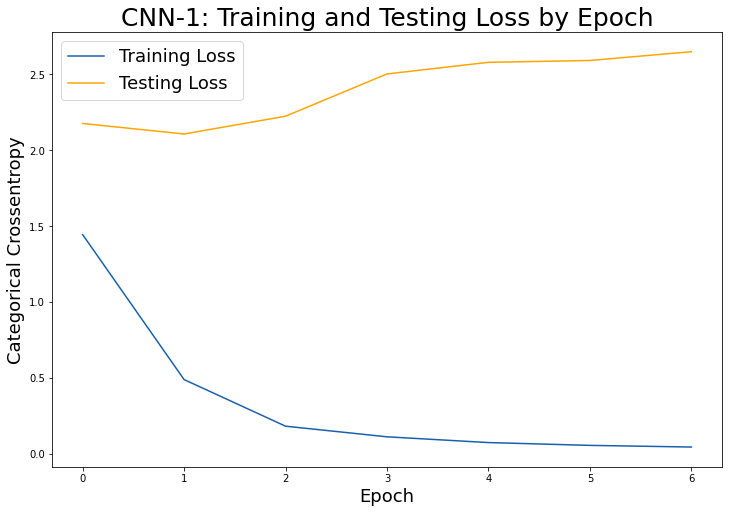

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss_1 = history.history['loss']
test_loss_1 = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss_1, label='Training Loss', color='#185fad')
plt.plot(test_loss_1, label='Testing Loss', color='orange')

# Set title
plt.title('CNN-1: Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)


plt.legend(fontsize = 18);

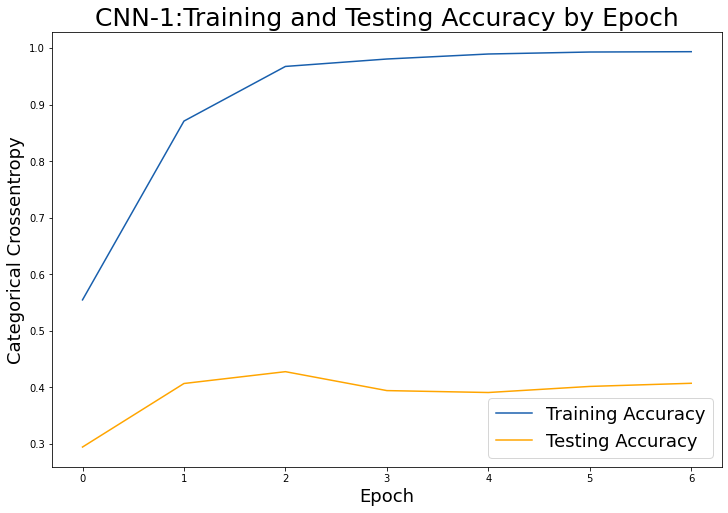

In [ ]:
# Check out our train acc and test acc over epochs.
train_acc_1 = history.history['accuracy']
test_acc_1 = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_acc_1, label='Training Accuracy', color='#185fad')
plt.plot(test_acc_1, label='Testing Accuracy', color='orange')

# Set title
plt.title('CNN-1:Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)


plt.legend(fontsize = 18);

# Evaulation

In [ ]:
classes = {"c0": "safe driving", 
           "c1": "texting - right", 
           "c2": "talking on the phone - right", 
           "c3": "texting - left",
           "c4": "talking on the phone - left", 
           "c5": "operating the radio", 
           "c6": "drinking", 
           "c7": "reaching behind",
           "c8": "hair and makeup", 
           "c9": "talking to passenger"}

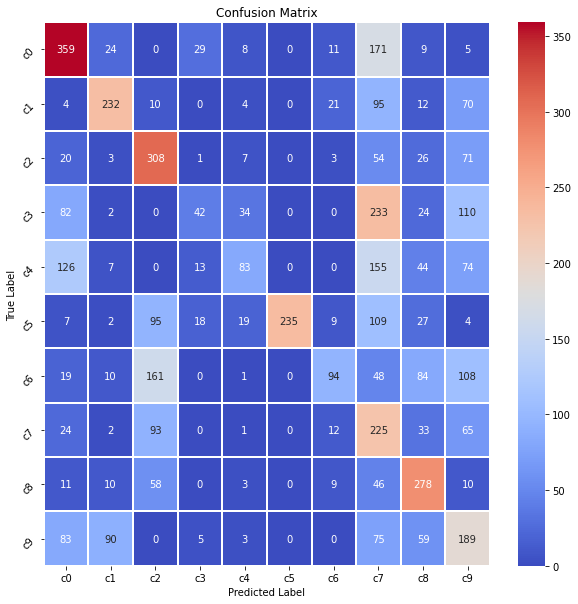

              precision    recall  f1-score   support

           0       0.49      0.58      0.53       616
           1       0.61      0.52      0.56       448
           2       0.42      0.62      0.51       493
           3       0.39      0.08      0.13       527
           4       0.51      0.17      0.25       502
           5       1.00      0.45      0.62       525
           6       0.59      0.18      0.27       525
           7       0.19      0.49      0.27       455
           8       0.47      0.65      0.54       425
           9       0.27      0.38      0.31       504

    accuracy                           0.41      5020
   macro avg       0.49      0.41      0.40      5020
weighted avg       0.50      0.41      0.40      5020



In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=classes,
                yticklabels=classes,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label', rotation=90)
    plt.xlabel('Predicted Label')
    plt.yticks(rotation=45)
    plt.show()

y_pred = model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred = np.argmax(y_pred, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred)

print(classification_report(max_y_test, max_y_pred))


# Predicted Images

In [ ]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

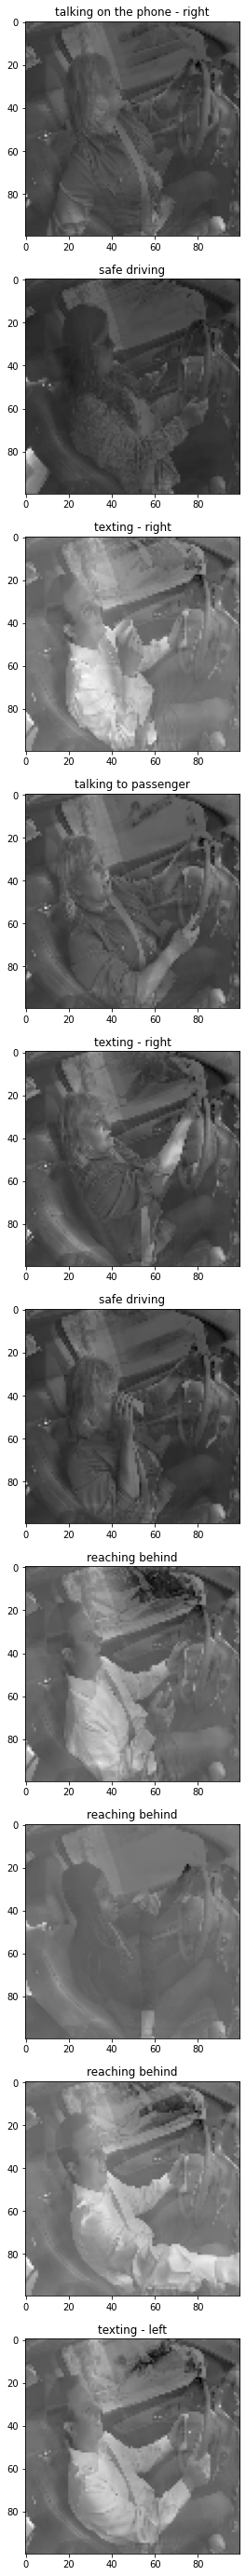

In [ ]:
# labels is the image array
i = 0
fig, ax = plt.subplots(10, 1, figsize = (50,50))

for i in range(10):
    ax[i].imshow(X_test[i].squeeze(),cmap = 'gray')
    preds_class = 'C'+str(np.where(y_pred[i] == np.amax(y_pred[i]))[0][0])
    ax[i].set_title(tags[preds_class])
    plt.show

We will use the results of the CNN model as our baseline for further improvements.

Next we will explore the use of othe deep learning models such as pre-trained models such as VGG16, Xception, Mobilnet that are proven to be popular in the industry for computer vision projects